In [1]:
import numpy as np
import pandas as pd
from tiger.io import read_image, write_image
from tiger.resampling import resample_image, resample_mask
from tiger.patches import PatchExtractor3D
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.optim import Adam
import random
from torchsummary import summary
from torch.utils.data import DataLoader
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Data exploration - xVertSeg
1. Load the data and scores
2. Resample images and masks
3. Extract 3D patches from mask (using a centre voxel and fixed size patches)
4. Match the patches with the corresponding scores and check if it makes sense

In [2]:
# 25 images, 15 masks and annotations (img 1-15), (note all in the same order)
img_paths = [os.path.join('../datasets/xvertseg/images', file) for file in sorted(os.listdir('../datasets/xvertseg/images'))]
msk_paths = [os.path.join('../datasets/xvertseg/masks', file) for file in sorted(os.listdir('../datasets/xvertseg/masks'))]
scores = pd.read_csv('../datasets/xvertseg/scores.csv', header=None).to_numpy().reshape(15, 5, 2)

In [3]:
imgs = []
msks = []
hdrs = []

# load images with headers and resample to (1, 1, 1) spacing
for path in tqdm(img_paths[:5]):
    image, header = read_image(path)
    resampled_img = resample_image(image, header.spacing, [1, 1, 1])  # resample image
    imgs.append(resampled_img)
    
# load masks
for path in tqdm(msk_paths[:5]):
    mask, header = read_image(path)
    resampled_mask = resample_mask(mask, header.spacing, [1, 1, 1])  # resample mask
    msks.append(resampled_mask)

100%|██████████| 5/5 [00:15<00:00,  3.02s/it]


In [4]:
# after loading and resampling we can check an imagine with its mask
i = 3
img = imgs[i]
msk = msks[i] 
score = scores[i]
plt_msk = np.ma.masked_where(msk == 0, msk)

print(img.shape)
print(msk.shape)

(435, 435, 218)
(435, 435, 218)


[array([221, 301, 157]), array([216, 296, 127]), array([214, 289,  96]), array([216, 282,  66]), array([214, 282,  38])]


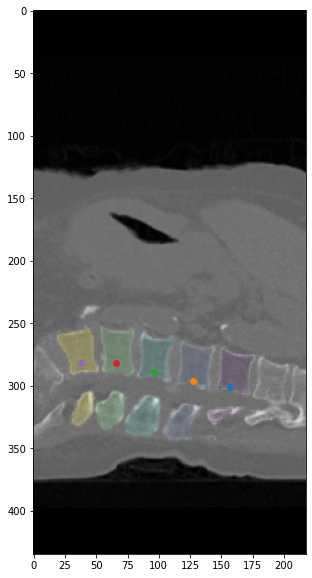

In [5]:
# next we will see how to extract patches of each vertebrae (from the mask) and match them with the scores 
labels = np.unique(msk)[1:]
centres = [np.mean(np.argwhere(msk == l), axis=0, dtype=int) for l in labels]
mid_slice = img.shape[0] // 2
print(centres)

# plot centres
plt.figure(figsize=(10,10))
plt.imshow(img[mid_slice,:,:], cmap='gray')
plt.imshow(plt_msk[mid_slice,:,:], alpha=0.2)

for c in centres:
    y, x = c[1], c[2]
    plt.scatter(x, y)
plt.show()

In [6]:
# 2d or 3d patches?
patch_size = (100, 150, 75)
patch_extracter = PatchExtractor3D(msk)
patches = []

for label, centre in zip(labels, centres):
    patch = patch_extracter.extract_cuboid(centre, patch_size)
    patch = np.where(patch == label, 1, 0)                    # filter patch to only contain this vertebrae
    patches.append(patch)

[[0 0]
 [0 0]
 [1 3]
 [1 3]
 [1 1]]
[0 0 1 1 1]


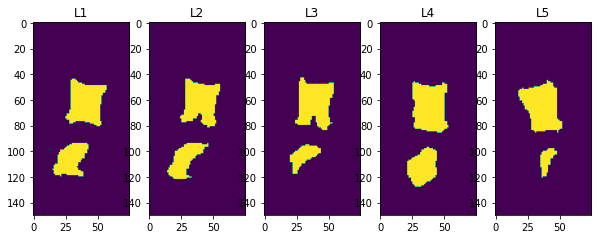

In [7]:
# binarize the score, to fracture or no fracture (0, 0)
binarized_score = np.any(score > 0, axis=1).astype(int)
print(score)
print(binarized_score)

plt.figure(figsize=(10, 10))

for i, patch in enumerate(patches):
    plt.subplot(1, 5, i + 1)
    plt.imshow(patch[50,:,:])
    plt.title('L{}'.format(i+1))

Scores are kept in a (5,2) array, consisting of a grade and case for each of the 5 vertebrae ($5*2=10$).
To keep it simple we will first convert this to a (5,) binary array, which just indicates a fracture or not (0,0).

## Creating a simple dataset 
These 3D patches look alright for a first step and we can now match them to the associated scores for each vertrbrae.
In the next step we'll make a simple dataset using what we've just seen. There would normally by 10 categories to predict, since case$=0$ always has a grade of $0$ and for the rest of the three 3 cases there is 3 grades.
Note that there is a order/ranking in these classes. For example, grade-2 and grade-3 vertebrae are both fractured, but grade-2 is considered less severe and thus closer to the healthy class (grade 0).

**For now we will deal with a binary label that indicates just whether this vertebrae is fractured or not.**

**TODO:**
1. Make training and validation balanced set of vertebrae (instead of extracting vertebrae for each image, mix them?)
2. Verify samples are OK
3. Should we use another dtype? since its a binary mask

In [8]:
class Dataset(torch.utils.data.Dataset):
    'Dataset class for a simple dataset containing masks of vertebrae and associated scores.'    
    def __init__(self, scores, masks, patch_size):        
        self.scores = scores.reshape(-1, scores.shape[2])             # shape = (N, 2), consisting of a grade and case for each of the 5 vertebrae, N is the number of vertebae
        self.scores = np.any(self.scores > 0, axis=1).astype(int)     # shape = (N, 1) for now make the scores binary, indicating fracture or not
        self.patches = []                                             # patch containig the mask of this vertebrae  
        
        # get patches
        for mask in masks:
            labels = np.unique(mask)[1:]
            centres = [np.mean(np.argwhere(mask == l), axis=0, dtype=int) for l in labels]
            patch_extracter = PatchExtractor3D(mask)
            
            for label, centre in zip(labels, centres):
                patch = patch_extracter.extract_cuboid(centre, patch_size)
                patch = np.where(patch == label, 1, 0)                    # filter patch to only contain this vertebrae
                self.patches.append(patch)
            
    def __len__(self):
        "Returns N, the number of vertebrae in this dataset."
        return len(self.patches)

    def __getitem__(self, i):
        "Return a single sample: a patch of mask containing one vertebrae and its binary score"
        # add channel dimension
        X = torch.tensor(self.patches[i]).unsqueeze(0)
        y = torch.tensor(self.scores[i]).unsqueeze(0)
        return X, y

In [9]:
# lets construct train and validation generators, 
IDs = np.arange(len(msks))     
np.random.shuffle(IDs)

train_val_split = 0.8
n_train = int(0.8 * len(IDs))
train_IDs = IDs[:n_train]
val_IDs = IDs[n_train:]

print(train_IDs)
print(val_IDs)

[1 2 4 0]
[3]


In [ ]:
# do this differently (gives a warning)
imgs = np.asarray(imgs)
msks = np.asarray(msks)

# define batch and patch sizes
batch_size = 4
patch_size = (100, 150, 75)

# define train and val dataset
train_val_split = 0.8
train_set = Dataset(scores[train_IDs], msks[train_IDs], patch_size)
val_set = Dataset(scores[val_IDs], msks[val_IDs], patch_size)

# define train and val generators
train_loader = DataLoader(train_set, batch_size=batch_size)
val_loader = DataLoader(val_set, batch_size=batch_size)

In [11]:
print('Size train set: {}'.format(train_set.__len__()))
print('Size val set: {}'.format(val_set.__len__()))

# we can look at rate of which fractures occur in the data set
train_frac_freq  = np.sum(train_set.scores) / len(train_set.scores)
val_frac_freq   = np.sum(val_set.scores) / len(val_set.scores)

print('Frequency of fractures in train set: {}'.format(train_frac_freq))
print('Frequency of fractures in val set: {}'.format(val_frac_freq))

X, y =  next(iter(train_loader))
print('X shape: {}'.format(X.shape))
print('y shape: {}'.format(y.shape))

print('X type: {}'.format(X.dtype))
print('y type: {}'.format(X.dtype))

Size train set: 20
Size val set: 5
Frequency of fractures in train set: 0.65
Frequency of fractures in val set: 0.6
X shape: torch.Size([4, 1, 100, 150, 75])
y shape: torch.Size([4, 1])
X type: torch.int64
y type: torch.int64


## Construct and train a simple 3D CNN
Next we constract a simple 3D CNN that aims to perform binary classifcation (fractured, not fractured).

**Input shape =  (batch_size, channel, x, y, z)**

**Output shape = (batch_size, 1)**

* sigmoid at the end
* BCE loss to train

In [50]:
class CNN(nn.Module):
    """
    Initial (simple) 3D CNN, that performs binary classification with as input a 3D patch of mask of vertebrae.
    """
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = self.conv_block(1, 64)
        self.conv2 = self.conv_block(64, 128)
        self.conv3 = self.conv_block(128, 256)
        self.fc1 = nn.Linear(256 * 10 * 17 * 7, 256)
        self.fc2 = nn.Linear(256, 1)
        self.final = nn.Sigmoid()
        
    def conv_block(self, in_channels, out_channels):
        conv_block = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=(3, 3, 3)),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),
        )
        return conv_block
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)  
        x = self.conv3(x) 
        x = x.view(-1, 256 * 10 * 17 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        out = self.final(x)
        return out
    
# make a model put on gpu and print summary
model = CNN().to(device)
summary(model, input_size=(1, 100, 150, 75), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [4, 64, 98, 148, 73]           1,792
              ReLU-2       [4, 64, 98, 148, 73]               0
         MaxPool3d-3        [4, 64, 49, 74, 36]               0
            Conv3d-4       [4, 128, 47, 72, 34]         221,312
              ReLU-5       [4, 128, 47, 72, 34]               0
         MaxPool3d-6       [4, 128, 23, 36, 17]               0
            Conv3d-7       [4, 256, 21, 34, 15]         884,992
              ReLU-8       [4, 256, 21, 34, 15]               0
         MaxPool3d-9        [4, 256, 10, 17, 7]               0
           Linear-10                   [4, 256]      77,988,096
           Linear-11                     [4, 1]             257
          Sigmoid-12                     [4, 1]               0
Total params: 79,096,449
Trainable params: 79,096,449
Non-trainable params: 0
-------------------------

In [51]:
# define optimzer, nr of epochs
# TODO: try to overfit on a small data set
optimizer = Adam(model.parameters(), lr=0.0001)
epochs = 100

# train the model
for epoch in range(epochs):   
    sum_loss_epoch = 0
    
    for X, y in train_loader: 
        # put data on gpu
        X, y = X.to(device, dtype=torch.float), y.to(device, dtype=torch.float)
        
        # set parameter gradients to 0
        optimizer.zero_grad()
        
        # forward a batch
        y_pred = model(X)  

        # compute BCE loss and update parameters
        bce = nn.BCELoss()
        loss = bce(y_pred, y)
        loss.backward()
        optimizer.step()
        sum_loss_epoch += loss.item()
        
    print('Epoch: {}, loss {}'.format(epoch, sum_loss_epoch / len(train_loader)))

Epoch: 0, loss 0.8490960478782654
Epoch: 1, loss 0.6619838237762451
Epoch: 2, loss 0.6320719242095947
Epoch: 3, loss 0.6196460843086242
Epoch: 4, loss 0.6080237030982971
Epoch: 5, loss 0.5831033945083618
Epoch: 6, loss 0.5467948377132416
Epoch: 7, loss 0.49599658846855166
Epoch: 8, loss 0.42670850157737733
Epoch: 9, loss 0.33770833611488343
Epoch: 10, loss 0.23604437485337257
Epoch: 11, loss 0.18451488092541696
Epoch: 12, loss 0.1129040077328682
Epoch: 13, loss 0.0820175681845285
Epoch: 14, loss 0.15986080868169666
Epoch: 15, loss 0.141767825190891
Epoch: 16, loss 0.17638071915134787
Epoch: 17, loss 0.17063546273857355
Epoch: 18, loss 0.06579130454920232
Epoch: 19, loss 0.08897222930099816
Epoch: 20, loss 0.031214147713035344
Epoch: 21, loss 0.03143151942640543
Epoch: 22, loss 0.013617665157653391
Epoch: 23, loss 0.010647845722269266
Epoch: 24, loss 0.0065457261545816435
Epoch: 25, loss 0.004171997759840451
Epoch: 26, loss 0.00357777509780135
Epoch: 27, loss 0.0025419885001610964
Epoch